In [191]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as prop
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12.5, 4)

In [192]:
#Here we simulate two groups- A and B with size 110 and 220. We also simulate who improved in A and B, 50, 75
group_A = 110
gotBetter_A = 50
group_B = 220
gotBetter_B = 75

percent_A = float(gotBetter_A)/float(group_A)*100
percent_B = float(gotBetter_B)/float(group_B)*100
print("The mean improvment for group A is: %.2f. The mean for group B is: %.2f" % (percent_A, percent_B))

The mean improvment for group A is: 45.45. The mean for group B is: 34.09


In [193]:
data_A = np.r_[[0] * (group_A - gotBetter_A), [1] * gotBetter_A]
data_B = np.r_[[0] * (group_B - gotBetter_B), [1] * gotBetter_B]

In [194]:
#Here we generate our prior assumptions. Since I don't have a clear idea of what the prior should be, 
#we will use a uniform prior with equal likelihood between 0 and 1.
p_A = pm.Uniform('p_A', lower=0, upper=1)
p_B = pm.Uniform('p_B', lower=0, upper=1)

IF we had a strong belief about the effectiveness of treatment, we could use another prior.


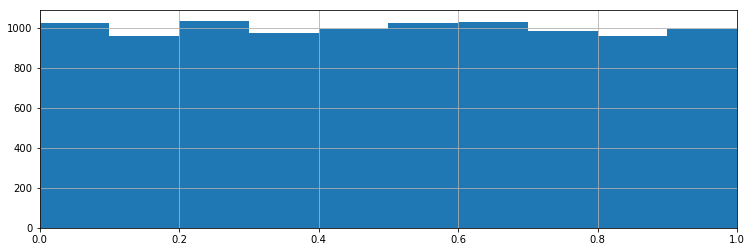

In [195]:
#Plot the prior, just to ensure it is what we expect.
print ("IF we had a strong belief about the effectiveness of treatment, we could use another prior.")
p_A_vars = [p_A.random() for i in range(10000)]
plt.hist(p_A_vars, bins=10)
plt.xlim(0, 1);
plt.grid(True);

In [196]:
#This returns the difference between A and B
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

In [197]:
#This adds the data we have generated to our prior beliefs. 
#In essence, it blends what we thought before with the newly seen data. 
obs_A = pm.Bernoulli("obs_A",p_A, value = data_A, observed = True)
obs_B = pm.Bernoulli("obs_B", p_B, value = data_B, observed = True)

#Here we do the MCMC sampling
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 3.1 sec

In [198]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

The graphs below show the distrobutions for the probability of success for A and B, 
 
as well as the probability of the difference between the groups


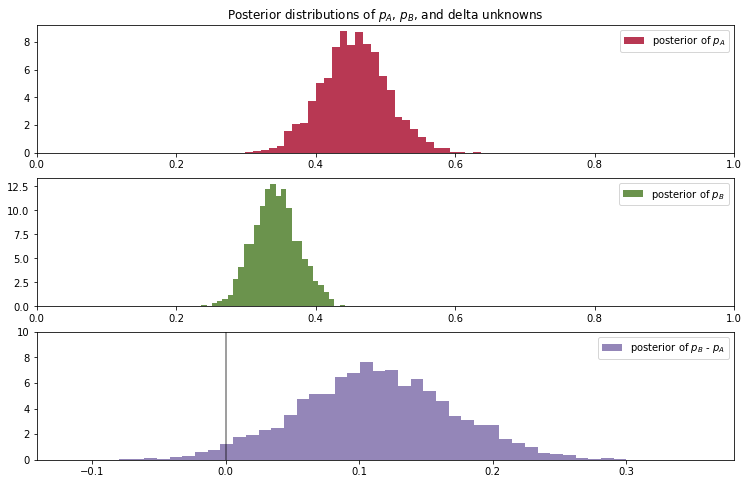

In [199]:
print("""The graphs below show the distrobutions for the probability of success for A and B, \n 
as well as the probability of the difference between the groups""")

figsize(12.5, 8)
ax = plt.subplot(3, 1, 1)

plt.xlim(0, 1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.8,
label="posterior of $p_A$", color="#A60628", normed=True,
edgecolor= "none")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(3, 1, 2)

plt.xlim(0, 1)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.8,
        label="posterior of $p_B$", color="#467821", normed=True,
        edgecolor = "none")
plt.legend(loc="upper right")

ax = plt.subplot(3, 1, 3)
plt.ylim(0,10)
plt.hist(delta_samples, histtype='stepfilled', bins=50, alpha=0.8,
        label="posterior of $p_B$ - $p_A$", color="#7A68A6",normed=True,
        edgecolor = "none")
plt.legend(loc="upper right")
plt.vlines(0, 0, 120, color="black", alpha = .5)

plt.show()

In [200]:
print "Probability treatment A is better than treatment B: %.2f" % ((delta_samples > 0).mean()*100)

Probability treatment A is better than treatment B: 97.54


In [201]:
#We can also ask questions like, what is the chance A is better than B by some percent
print "Probability treatment A is better than treatment B by 5 percent: %.2f" % ((delta_samples > .05).mean()*100)

Probability treatment A is better than treatment B by 5 percent: 86.27


In [202]:
#Lets compare this to a normal proprtion test
better = np.array([50, 75])
obs = np.array([110, 220])
tat, pval = prop.proportions_ztest(better, obs, alternative='larger')
print("Using a standard z-test of proportions, the p value that A is better than B is: %.3f"% pval)

Using a standard z-test of proportions, the p value that A is better than B is: 0.022


In [203]:
#The results of the Bayesian method and the z-test are very similar
#Both suggest A is indedd more effective than B